In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../../..'))

if module_path not in sys.path:
    print(f"Adding [{module_path}] to sys.path")
    sys.path.append(module_path)

# Comparing ALCS Latent-Learning capabilities

Approach to compare *latent-learning* capabilities of various ALCS systems.

The following aspects will be compared:

- ability learn consequences of performing action in certain states (build accurate internal model of the environment),
- ability to generalize,
- size of internal classifier population,
- relative operation time

In [2]:
import pathlib

import matplotlib as mpl
import matplotlib.pyplot as plt


from lcs import Perception

import gym
# noinspection PyUnresolvedReferences
import gym_yacs_simple_maze
# noinspection PyUnresolvedReferences
import gym_corridor
# noinspection PyUnresolvedReferences
import gym_grid
# noinspection PyUnresolvedReferences
import gym_multiplexer

# Logger
# import logging
# logging.basicConfig(level=logging.DEBUG)

# Common plot settings
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['lines.linewidth'] = 2

# Gecco submission settings
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2

In [3]:
from notebooks import get_from_cache_or_run

# Import common utils code
%run utils/experiments.py
%run utils/plotting.py

In [4]:
cache_prefix = f'{pathlib.Path().absolute()}/cache/'
cache_prefix

'/home/arc/Projects/pwr/pyalcs-experiments/notebooks/publications/latent-learning-for-anticipatory-classifier-systems-in-discretized-real-valued-environments/cache/'

# Environments
This section presents the multi-step environments that were used in experiments.

1. [Simple Maze](#Simple-Maze) - Simpler maze variant with limited perception and available actions

Discretized real-valued.

2. [Corridor](#Corridor) - one dimension and two actions are available. The agent is checked is optimal number of classifiers is created
3. [Grid](#Grid) - two dimensions and four actions.

Maybe (todo)

4. Maze4 / Maze6 - More advanced mazes (bigger perception and available actions)

## Simple Maze
In each trial the agent is placed in __S__ tile. It can perceive 4 values (N, E, S and W) and can move in each cardinal direction. The trial ends when tile **F** is reached.

![simple-maze](img/simple-maze-env.png)

Minimal number of classifiers to model the environment is __20__. The number of _"fully-specialized"_ classifiers is **32**.

In [5]:
simple_maze = gym.make('SimpleMaze-v0')
simple_maze_perceptions = simple_maze.env.PERCEPTIONS
simple_maze_transitions = simple_maze.env.TRANSITIONS

# LCS helpers
def simple_maze_knowledge(pop, env):
    all_transitions = 0
    nr_correct = 0

    for s0, action_states in env.env.TRANSITIONS.items():
        for action_state in action_states:
            all_transitions += 1

            action = action_state.action.value
            s1 = action_state.state

            p0 = env.env._perception(s0)
            p1 = env.env._perception(s1)
            
            if any([True for cl in pop if cl.predicts_successfully(p0, action, p1)]):
                nr_correct += 1
            
    return nr_correct / all_transitions

def simple_maze_metrics_collect(agent, env):
    population = agent.population
    return {
        'pop': len(population),
        'knowledge': simple_maze_knowledge(population, env),
        'generalization': generalization_score(population)
    }

# DynaQ helpers
def simple_maze_perception_to_int(p0):
    p0m = list(map(int, p0))
    return list(simple_maze_perceptions.keys())[list(simple_maze_perceptions.values()).index(p0m)]

def simple_maze_knowledge_calculator(model, env):
    all_transitions = 0
    nr_correct = 0

    for s0, moves in simple_maze_transitions.items():
        for move in moves:
            a = move.action.value
            s1 = move.state
            
            all_transitions += 1
            if s0 in model and a in model[s0] and model[s0][a][0] == s1:
                nr_correct += 1

    return nr_correct / all_transitions

In [6]:
%%time

common_params = {
    'env': simple_maze,
    'observation_wrapper': None,
    'classifier_length': 4,
    'possible_actions': 4,
    'learning_rate': 0.1,
    'metrics_trial_freq': 1,
    'metrics_fcn': simple_maze_metrics_collect,
    'explore_trials': 250
}

yacs_params = {
    'trace_length': 3,
    'estimate_expected_improvements': False,
    'feature_possible_values': [{'0', '1'}] * 4
}

dynaq_params = {
    'num_states': len(simple_maze_perceptions),
    'perception_to_state_mapper': simple_maze_perception_to_int,
    'knowledge_fcn': simple_maze_knowledge_calculator
}

simple_maze_metrics = get_from_cache_or_run(
    f'{cache_prefix}/SimpleMaze.dill', 
    lambda: avg_experiments(lambda: run_experiment_parallel(common_params, yacs_params=yacs_params, dynaq_params=dynaq_params), n=50))

simple_maze_metrics

CPU times: user 2.4 ms, sys: 733 µs, total: 3.14 ms
Wall time: 12.5 ms


time  knowledge  population  generalization  trial_steps
agent trial                                                              
acs   0      0.026497   0.650667       14.32        0.610774          NaN
      1      0.036585   0.718667       15.92        0.583411          NaN
      2      0.038625   0.778667       17.18        0.565168          NaN
      3      0.043096   0.798667       17.72        0.554609          NaN
      4      0.046725   0.816000       18.22        0.545645          NaN
...               ...        ...         ...             ...          ...
yacs  245    0.050916   0.982667       36.26        0.275414          NaN
      246    0.069559   0.982667       36.34        0.275415          NaN
      247    0.068837   0.986667       36.38        0.275416          NaN
      248    0.058549   0.988000       36.40        0.275417          NaN
      249    0.074729   0.985333       36.52        0.275419          NaN

[1750 rows x 5 columns]

/home/arc/Projects/pwr/pyalcs-experiments/notebooks/publications/latent-learning-for-anticipatory-classifier-systems-in-discretized-real-valued-environments/utils/plotting.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 1].set_xticklabels(labels, rotation=60)


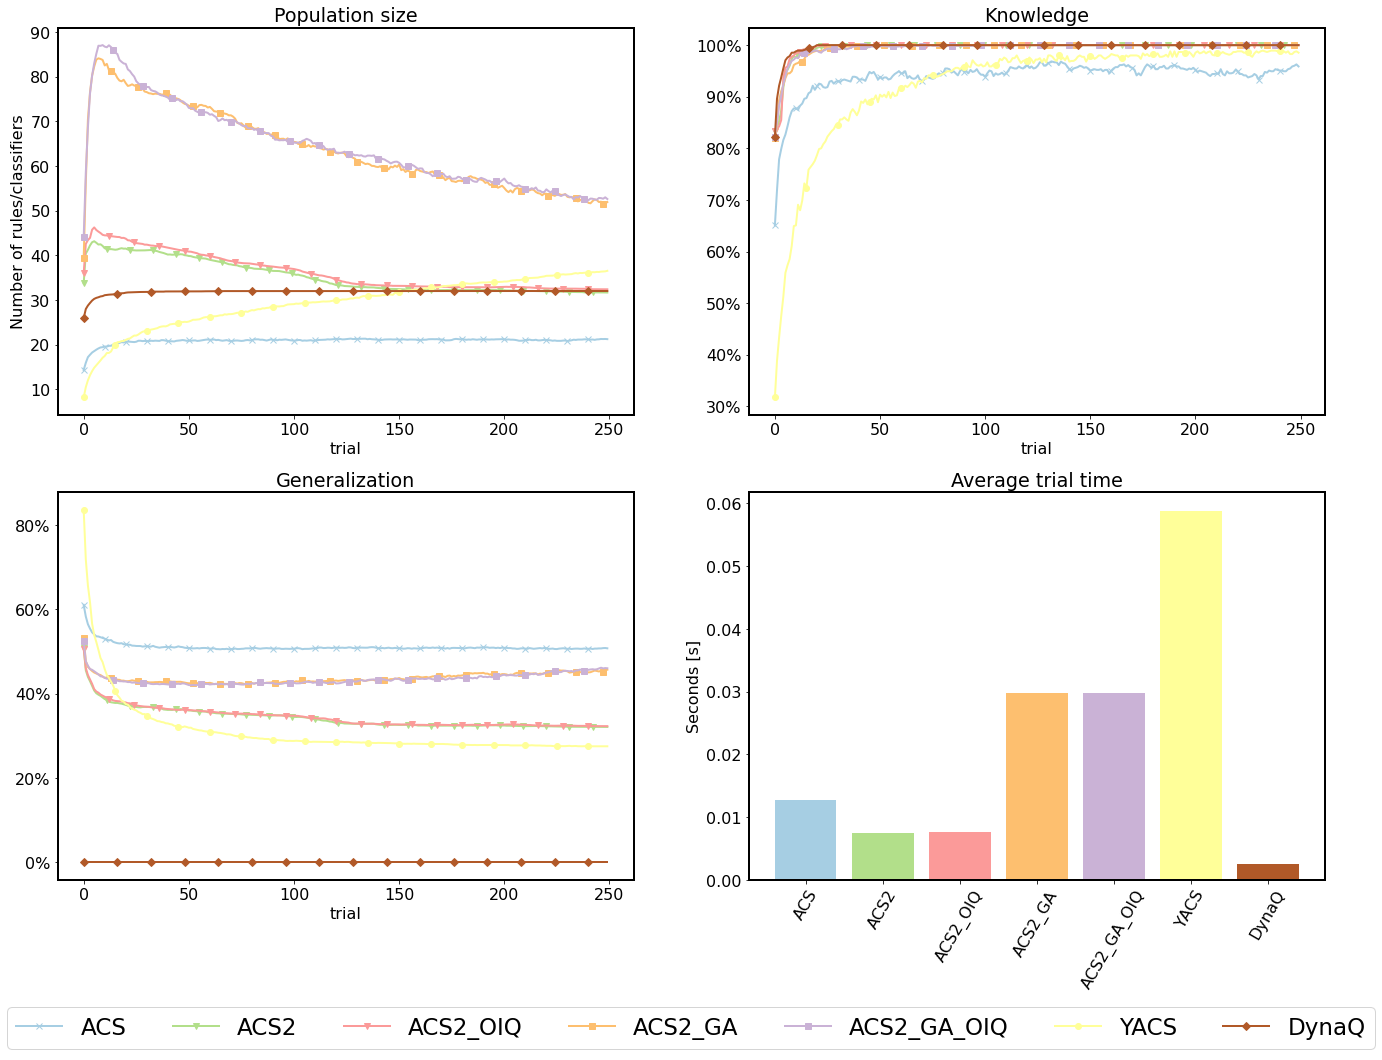

In [7]:
%run utils/plotting.py

plot_comparison(simple_maze_metrics)
plt.savefig('plots/simple-maze.pdf', transparent=False, bbox_inches='tight')

## Corridor

![corridor](img/corridor-env.png)

In [8]:
corridor = gym.make('corridor-20-v0')

# LCS helpers
def corridor_knowledge(pop, env):
    transitions = env.env.get_transitions()
    reliable = [c for c in pop if c.is_reliable()]
    nr_correct = 0

    for start, action, end in transitions:
        p0 = Perception((str(start),))
        p1 = Perception((str(end),))

        if any(
            [True for cl in reliable if cl.predicts_successfully(p0, action, p1)]):
            nr_correct += 1

    return nr_correct / len(transitions)


def corridor_metrics_collect(agent, env):
    population = agent.population
    return {
        'pop': len(population),
        'knowledge': corridor_knowledge(population, env),
        'generalization': generalization_score(population)
    }

class CorridorObservationWrapper(gym.ObservationWrapper):
    def observation(self, observation):
        return observation,


# DynaQ helpers
def dynaq_corridor_knowledge_calculator(model, env):
    transitions = env.env.get_transitions()
    nr_correct = 0

    for (s0, a, s1) in transitions:
        if s0 in model and a in model[s0] and model[s0][a][0] == s1:
            nr_correct += 1

    return nr_correct / len(transitions)

In [9]:
%%time

common_params = {
    'env': corridor,
    'observation_wrapper': CorridorObservationWrapper,
    'classifier_length': 1,
    'possible_actions': 2,
    'learning_rate': 0.1,
    'metrics_trial_freq': 1,
    'metrics_fcn': corridor_metrics_collect,
    'explore_trials': 300
}

yacs_params = {
    'trace_length': 3,
    'estimate_expected_improvements': False,
    'feature_possible_values': [set(str(i) for i in range(19)),]
}

dynaq_params = {
    'num_states': corridor.env.observation_space.n,
    'perception_to_state_mapper': lambda p: int(p),
    'knowledge_fcn': dynaq_corridor_knowledge_calculator
}

corridor_metrics = get_from_cache_or_run(
    f'{cache_prefix}/Corridor.dill', 
    lambda: avg_experiments(lambda: run_experiment_parallel(common_params, yacs_params=yacs_params, dynaq_params=dynaq_params), n=50))

corridor_metrics

CPU times: user 1.36 ms, sys: 247 µs, total: 1.61 ms
Wall time: 2.47 ms


time  knowledge  population  generalization  trial_steps
agent trial                                                              
acs   0      0.016699   0.031892       27.66        0.081256          NaN
      1      0.008816   0.044865       29.94        0.071178          NaN
      2      0.007971   0.052973       32.18        0.064049          NaN
      3      0.007465   0.058919       33.46        0.061044          NaN
      4      0.007960   0.062162       34.20        0.059611          NaN
...               ...        ...         ...             ...          ...
yacs  295    0.058485   1.000000       38.00        0.000000          NaN
      296    0.052730   1.000000       38.00        0.000000          NaN
      297    0.054725   1.000000       38.00        0.000000          NaN
      298    0.057422   1.000000       38.00        0.000000          NaN
      299    0.056538   1.000000       38.00        0.000000          NaN

[2100 rows x 5 columns]

/home/arc/Projects/pwr/pyalcs-experiments/notebooks/publications/latent-learning-for-anticipatory-classifier-systems-in-discretized-real-valued-environments/utils/plotting.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 1].set_xticklabels(labels, rotation=60)


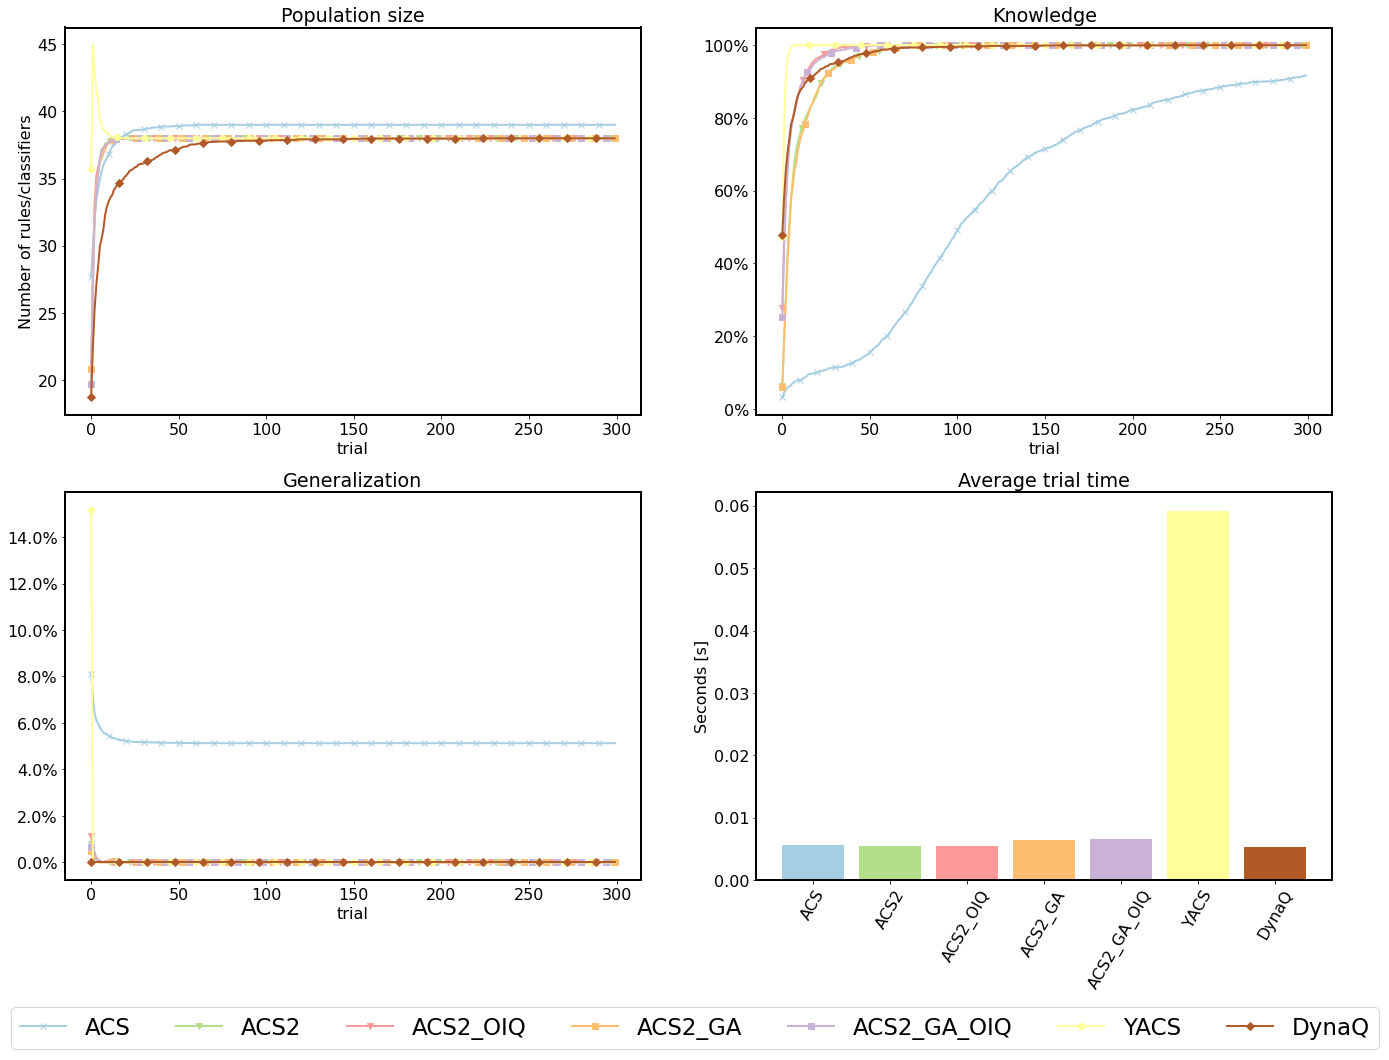

In [10]:
plot_comparison(corridor_metrics)
plt.savefig('plots/corridor.pdf', transparent=False, bbox_inches='tight')

## Grid
![grid](img/grid-env.png)

In [11]:
grid = gym.make('grid-20-v0')
grid_transitions = grid.env._transitions

unique_states = set()
for (s0, a, s1) in grid_transitions:
    unique_states.add(s0)
    unique_states.add(s1)

grid_state_mapping = {idx: s for idx, s in enumerate(unique_states)}


# LCS helpers
def grid_knowledge(population, env):
    transitions = env.env.get_transitions()
    reliable = [c for c in population if c.is_reliable()]
    nr_correct = 0
    
    for start, action, end in transitions:
        p0 = Perception([str(el) for el in start])
        p1 = Perception([str(el) for el in end])
        
        if any([True for cl in reliable if cl.predicts_successfully(p0, action, p1)]):
            nr_correct += 1
    
    return nr_correct / len(transitions)

def grid_metrics_collector(agent, env):
    population = agent.population
    return {
        'pop': len(population),
        'knowledge': grid_knowledge(population, env),
        'generalization': generalization_score(population)
    }

# DynaQ helpers
def grid_perception_to_int(p0):
    p0m = tuple(map(int, p0))
    return list(grid_state_mapping.keys())[list(grid_state_mapping.values()).index(p0m)]

def dynaq_grid_knowledge_calculator(model, env):
    all_transitions = 0
    nr_correct = 0

    for p0, a, p1 in grid_transitions:
        s0 = grid_perception_to_int(p0)
        s1 = grid_perception_to_int(p1)

        all_transitions += 1
        if s0 in model and a in model[s0] and model[s0][a][0] == s1:
            nr_correct += 1

    return nr_correct / all_transitions

In [12]:
%%time

common_params = {
    'env': grid,
    'observation_wrapper': None,
    'classifier_length': 2,
    'possible_actions': 4,
    'learning_rate': 0.1,
    'metrics_trial_freq': 1,
    'metrics_fcn': grid_metrics_collector,
    'explore_trials': 250
}

yacs_params = {
    'trace_length': 3,
    'estimate_expected_improvements': False,
    'feature_possible_values': [
        set(str(i) for i in range(20)),
        set(str(i) for i in range(20))
    ]
}

dynaq_params = {
    'num_states': len(grid_state_mapping),
    'perception_to_state_mapper': grid_perception_to_int,
    'knowledge_fcn': dynaq_grid_knowledge_calculator
}

grid_metrics = get_from_cache_or_run(
    f'{cache_prefix}/Grid.dill', 
    lambda: avg_experiments(lambda: run_experiment_parallel(common_params, yacs_params=yacs_params, dynaq_params=dynaq_params), n=25))

grid_metrics

CPU times: user 1.45 ms, sys: 0 ns, total: 1.45 ms
Wall time: 1.78 ms


time  knowledge  population  generalization  trial_steps
agent trial                                                               
acs   0       0.226688   0.080474       57.40        0.535719          NaN
      1       0.555147   0.224506       71.88        0.528162          NaN
      2       0.288368   0.290224       73.84        0.527273          NaN
      3       0.494004   0.387589       75.28        0.526696          NaN
      4       0.513783   0.484480       76.16        0.526284          NaN
...                ...        ...         ...             ...          ...
yacs  245    12.876102   0.945349      824.52        0.067628          NaN
      246    11.069715   0.945349      824.52        0.067628          NaN
      247    10.645219   0.945349      824.52        0.067628          NaN
      248    12.841539   0.945349      824.52        0.067628          NaN
      249     8.651179   0.945349      824.52        0.067628          NaN

[1750 rows x 5 columns]

/home/arc/Projects/pwr/pyalcs-experiments/notebooks/publications/latent-learning-for-anticipatory-classifier-systems-in-discretized-real-valued-environments/utils/plotting.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 1].set_xticklabels(labels, rotation=60)


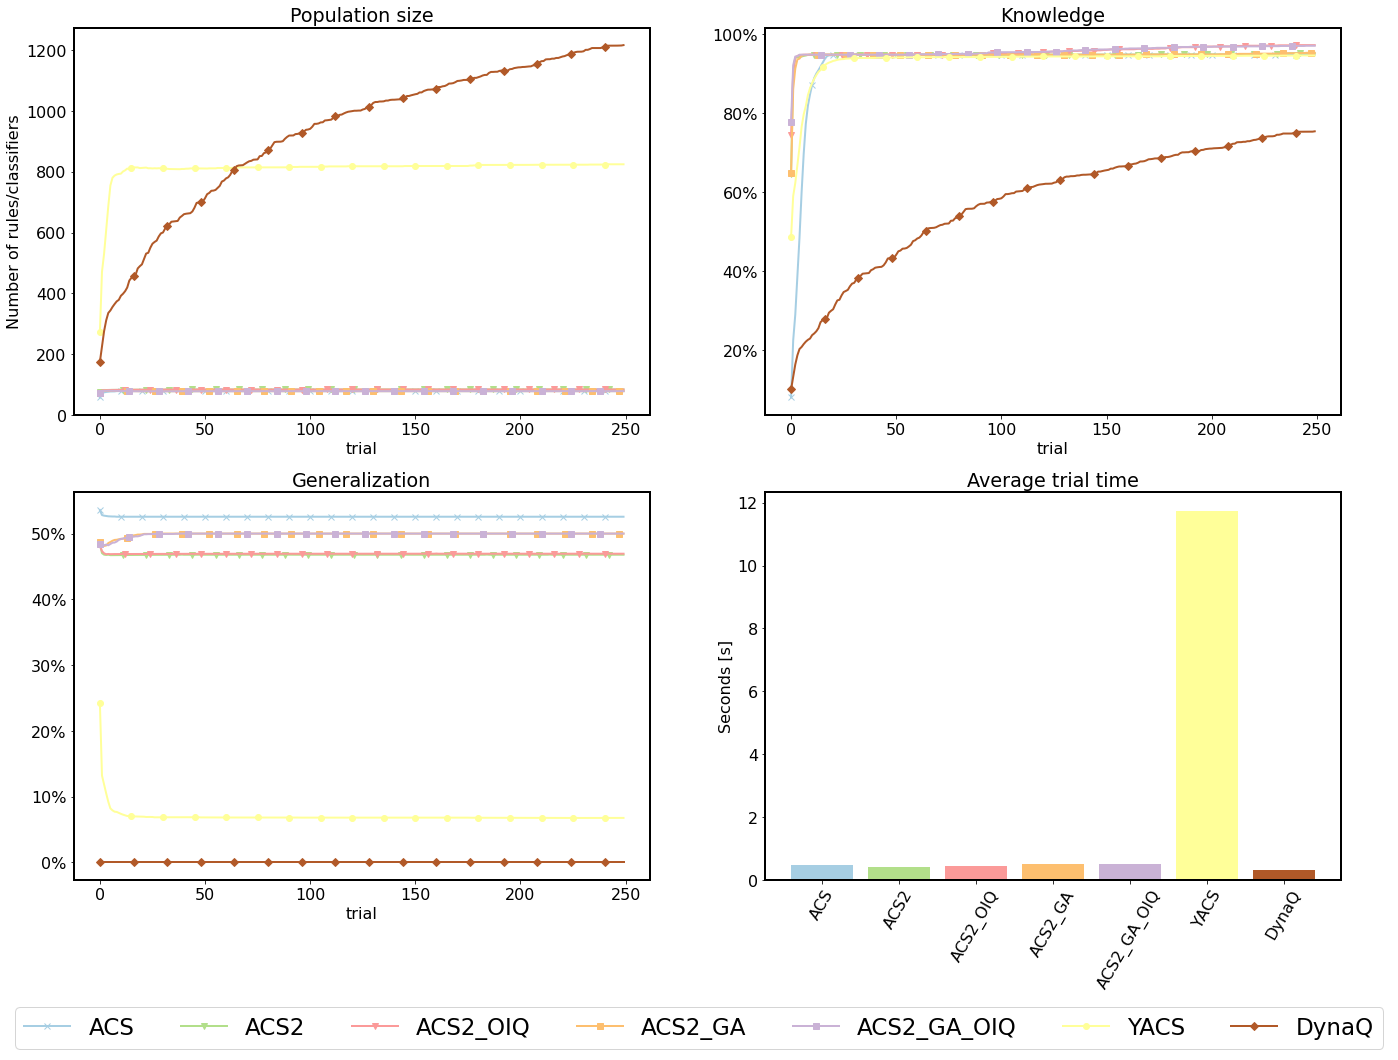

In [13]:
plot_comparison(grid_metrics)
plt.savefig('plots/grid.pdf', transparent=False, bbox_inches='tight')

### Grid classifier comparison
Evaluate some LCS and examine how the population of classifier looks like for a certain state.

In [14]:
def print_cls_comparison(perception, common_params, acs_params={}, acs2_params={}, yacs_params={}):
    def evaluate(common_params, acs_params={}, acs2_params={}, yacs_params={}):
        common_params['explore_trials'] = 25
        result = dict()

        run_acs(result, 'acs', **{**common_params, **acs_params})
        run_acs2(result, 'acs2', **{**common_params, **acs2_params, **{'do_ga': False, 'initial_q': 0.5}})
        run_yacs(result, 'yacs', **{**common_params, **yacs_params})

        return result

    def print_cl(cl):
        moves = ['←', '→', '↑', '↓']
        return f"{cl.condition} {moves[cl.action]} {cl.effect}"

    # cache function above
    grid_cls_comparison = get_from_cache_or_run(
        f'{cache_prefix}/Grid-classifiers.dill',
        lambda: evaluate(common_params, yacs_params=yacs_params))

    # compare algorithms
    print('\nACS Population')
    for cl in sorted(grid_cls_comparison['acs'][0].form_match_set(perception), key=lambda cl: cl.action):
        print(f"{print_cl(cl)}")

    print('\nACS2 Population')
    for cl in sorted(grid_cls_comparison['acs2'][0].form_match_set(perception), key=lambda cl: cl.action):
        print(f"{print_cl(cl)}")

    print('\nYACS Population')
    for cl in sorted(grid_cls_comparison['yacs'][0].form_match_set(perception), key=lambda cl: cl.action):
        print(f"{print_cl(cl)}")

print_cls_comparison(Perception(('18', '19')), common_params, yacs_params=yacs_params)


ACS Population
## ← ##
18# ← 17#
## → ##
18# → 19#
## ↑ ##
## ↓ ##
#19 ↓ #18

ACS2 Population
18# ← 17#
18# → 19#
#19 ↑ ##
#19 ↓ #18

YACS Population
1819 ← 3#
1819 ← 17#
1819 → 7#
1819 → 19#
#19 ↑ ##
1819 ↓ #18


## rMPX

In [15]:
RMPX_SIZE = 6
RMPX_BINS = 10
rmpx = gym.make(f'real-multiplexer-{RMPX_SIZE}bit-v0')

_range, _low = (rmpx.observation_space.high - rmpx.observation_space.low, rmpx.observation_space.low)

RMPX_STEP = _range / RMPX_BINS

In [16]:
import itertools
import bitstring

class RealMultiplexerUtils:
    def __init__(self, size, ctrl_bits, bins, _range, _threshold=0.5):
        self._size = size
        self._ctrl_bits = ctrl_bits
        self._bins = bins
        self._step = _range / bins
        self._threshold = _threshold

        self._attribute_values = [list(range(0, bins))] * (size) + [[0, bins]]
        self._input_space = itertools.product(*self._attribute_values)
        self.state_mapping = {idx: s for idx, s in enumerate(self._input_space)}
        self.state_mapping_inv = {v: k for k, v in self.state_mapping.items()}

    def discretize(self, obs, _type=int):
        r = (obs + np.abs(_low)) / _range
        b = (r * RMPX_BINS).astype(int)
        return b.astype(_type).tolist()

    def reverse_discretize(self, discretized):
        return discretized * self._step[:len(discretized)]
    
    def get_transitions(self):
        transitions = []

        initial_dstates = [list(range(0, self._bins))] * (self._size)
        for d_state in itertools.product(*initial_dstates):
            correct_answer = self._get_correct_answer(d_state)

            if correct_answer == 0:
                transitions.append((d_state + (0,), 0, d_state + (self._bins,)))
                transitions.append((d_state + (0,), 1, d_state + (0,)))
            else:
                transitions.append((d_state + (0,), 0, d_state + (0,)))
                transitions.append((d_state + (0,), 1, d_state + (self._bins,)))

        return transitions

    def _get_correct_answer(self, discretized):
        estimated_obs = self.reverse_discretize(discretized)
        # B = np.where(estimated_obs > self._threshold, 1, 0)
        bits = bitstring.BitArray(estimated_obs > self._threshold)
        _ctrl_bits = bits[:self._ctrl_bits]
        _data_bits = bits[self._ctrl_bits:]

        return int(_data_bits[_ctrl_bits.uint])

In [17]:
rmpx_utils = RealMultiplexerUtils(RMPX_SIZE, 2, RMPX_BINS, _range)
print(f"Possible states: {len(rmpx_utils.state_mapping)}")

class DiscretizedWrapper(gym.ObservationWrapper):
    def observation(self, obs):
        return rmpx_utils.discretize(obs, _type=str)

def rmpx_knowledge(population, env):
    reliable = [c for c in population if c.is_reliable()]
    nr_correct = 0
    
    for start, action, end in rmpx_utils.get_transitions():
        p0 = Perception([str(el) for el in start])
        p1 = Perception([str(el) for el in end])
        
        if any([True for cl in reliable if cl.predicts_successfully(p0, action, p1)]):
            nr_correct += 1
    
    return nr_correct / len(rmpx_utils.get_transitions())

def rmpx_metrics_collector(agent, env):
    population = agent.population
    return {
        'pop': len(population),
        'knowledge': rmpx_knowledge(population, env),
        'generalization': generalization_score(population)
    }

# DynaQ helpers
def rmpx_perception_to_int(p0, discretize=True):
    if discretize:
        p0 = rmpx_utils.discretize(p0)
        
    return rmpx_utils.state_mapping_inv[tuple(p0)]

def dynaq_rmpx_knowledge_calculator(model, env):
    all_transitions = 0
    nr_correct = 0

    for p0, a, p1 in rmpx_utils.get_transitions():
        s0 = rmpx_perception_to_int(p0, discretize=False)
        s1 = rmpx_perception_to_int(p1, discretize=False)

        all_transitions += 1
        if s0 in model and a in model[s0] and model[s0][a][0] == s1:
            nr_correct += 1

    return nr_correct / len(rmpx_utils.get_transitions())

Possible states: 2000000


Knowledge calculation (creating transition matrix):
1. Generate all posible discretized states (with `0` at the end)
2. For each such a state estimate original perception (multiply by step size)
3. For each estimated perception obtain correct answer
4. For each estimate perception create two rows in transition matrix - for good and wrong answer. 


In [ ]:
%%time

common_params = {
    'env': rmpx,
    'observation_wrapper': DiscretizedWrapper,
    'classifier_length': RMPX_SIZE+1,
    'possible_actions': 2,
    'learning_rate': 0.1,
    'metrics_trial_freq': 100,
    'metrics_fcn': rmpx_metrics_collector,
    'explore_trials': 5_000
}

yacs_params = {
    'trace_length': 3,
    'estimate_expected_improvements': False,
    'feature_possible_values': [{str(i) for i in range(RMPX_BINS)}] * RMPX_SIZE + [{'0', '10'}]
}

dynaq_params = {
    'num_states': len(rmpx_utils.state_mapping),
    'perception_to_state_mapper': rmpx_perception_to_int,
    'knowledge_fcn': dynaq_rmpx_knowledge_calculator
}

rmpx_metrics = get_from_cache_or_run(
    f'{cache_prefix}/rmpx6.dill',
    lambda: avg_experiments(lambda: run_experiment_parallel(common_params, yacs_params=yacs_params, dynaq_params=dynaq_params), n=1))

rmpx_metrics

In [ ]:
plot_comparison(rmpx_metrics)
plt.savefig('plots/rmpx.pdf', transparent=False, bbox_inches='tight')